# Fractal features
**This script reads an square image and fits broken powerlaw to the power spectral density of it at 18 directions and then estimates the scale breaks for each individual direction. In addition, the code plots the breaks against dominant wind direction.** 

# Installing the required packages

In [1]:
# pip install powerlaw
# pip uninstall powerlaw

# Loading the required packages

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize
import powerlaw
import math
import cv2
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import seaborn as sns
import collections
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Read the data

In [3]:
### This function reads the wind data and tif image of the snow depth or vegetation.
### The inputs are: 
### "arg_tif": the name of the image,
### "arg_wind": the wind data file in csv format,
### "resolution": image resolution,
### "min_" the minimum value to plot,
### "max_" : the maximum value for plotting
### "S": If S==1 it saves the plot

def readtiff_(arg_tif, arg_wind,resolution,min_,max_,S):
    # Reading the image
    im = Image.open('{}.tif'.format(arg_tif))
    
    # Converting the tiff file to an array
    imarray = np.array(im)
    
    # Filter the noise
    imarray = np.where(imarray < 0, imarray-imarray, imarray)
    imarray = np.nan_to_num(imarray)
    imarray = np.where(imarray > 1000000, imarray-imarray, imarray)
    
    # Ploting the file and save it
    plt.figure(figsize=(10,10))
    plt.imshow(imarray,vmin=min_, vmax=max_)
    plt.colorbar()
    if S==1:
        plt.savefig('{}.png'.format(arg_tif),dpi=300)
    plt.show()
    
    # Read the wind data
    wind = pd.read_csv('{}.csv'.format(arg_wind))
    return imarray, resolution, wind  

## Read the tif file and wind data 
**(The wind data are selected from the first snowfall until 02/28/2017)**

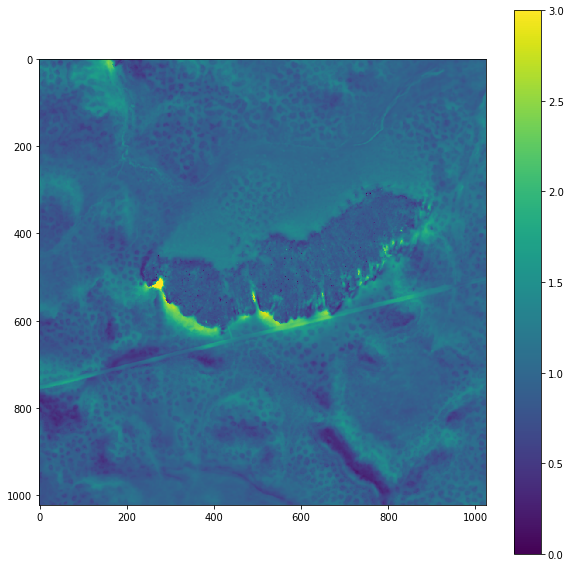

In [4]:
arg_tif = 'Site_A_20160926_2017_Snow_Depth'
arg_wind = 'A_for_scale_process'
imarray, resolution, wind = readtiff_(arg_tif, arg_wind,1,0,3,0)

# Power Spectral density Function

In [5]:
### This function computes the power spectral density (psd) for East-West and North-South directions and returns the frequency 
### and psd.
### The inputs are:
### "imarray": image array file.
### "direction": 'N' for North-South and 'E' for East-West direction.

def psd_(imarray,direction):
    psd0 = np.zeros(int(len(imarray)/2)+1)
    if direction == 'N':
        for i in range(0,len(imarray)):
            freqs, psd = signal.welch(imarray[:,i],nperseg=1024)
            psd0 = psd + psd0
    elif direction == 'E':
        for j in range(0,len(imarray)):
            freqs, psd = signal.welch(imarray[j,:],nperseg=1024)
            psd0 = psd + psd0
    return psd0/len(imarray), freqs    

## North-South

 **Compute the power spectral density for North-South direction**

In [6]:
psd_y, freqs = psd_(imarray,'N')

## East-West

**Compute the power spectral density for East-West direction**

In [7]:
psd_x, freqs = psd_(imarray,'E')

## Function to find breaks

In [8]:
### Segmented Linear Regression
### The main function is from 
### "https://datascience.stackexchange.com/questions/8457/python-library-for-segmented-regression-a-k-a-piecewise-regression"
### and I changed it for one and no breakpoint cases.

def SLR( freq, psd, init_ ):

    df = np.min( np.diff(freq) )
    ones = np.ones_like(freq)

    for i in range(10 ):
        # Linear regression:  solve A*x = psd
        R = np.maximum( freq - init_, 0 )
        S = (R > 0).astype(float)
        
        A = np.array([ ones, freq ] + [R] + [S] )
        x =  lstsq(A.transpose(), psd, rcond = None)[0]

        # Parameters identification:
        c = x[2:3]
        d = x[3:]
        
        # Update the breakpoint:
        init_new_ = init_ - d/c 
        
        if np.isnan(init_new_):
            break
            
        # Stop condition
        if np.max(np.abs(init_new_ - init_)) < df/5:
            break

        init_ = init_new_
        if np.isnan(init_):
            init_ = np.max(freq)
            break  
    return init_

## Break Plot function

In [9]:
### This function fits the powerlaw to the data and plots the fitted lines along side the breakpoint.
### The inputs are:
### "X": frequencies from the power spectral density function.
### "Y": psd from the power spectral density function.
### "resolution" : image resolution.
### "npixel" : lenght of the square image.
### "arg" : title for the plot.
### "S": If S==1 it saves the plot

def segment_plot(X, Y, resolution, npixel, arg, S):
    # Extracting the break point. 
    l  = SLR( np.log10(X[1:]), np.log10(Y[1:]), [-1] )
    
    # The frequency at breakpoint
    f_x = np.power(10,l[0])

    # Find the slope (powerlaw) and intercept of the lines fitted on the psd plot.
    # Broken powerlaw
    if len(X[X<f_x]) > 1 and len(X[X>f_x] > 1):                                     
        # Frequencies less than the frequency at the breakpoint
        y0 = Y[0:len(X[X<f_x])+1]
        x0 = X[0:len(X[X<f_x])+1]
        p0 = np.polyfit(np.log(x0[1:]), np.log(y0[1:]), 1) # Fit a line to psds
        z0 = np.polyval(p0,np.log(x0[1:]))
        B0 = -p0[0]                                        # First Power Law
        print('\u03B2_0:', B0)

        # Frequencies greater than the frequency at the breakpoint
        y = Y[len(X[X<f_x])-1:]
        x = X[len(X[X<f_x])-1:]
        p = np.polyfit(np.log(x), np.log(y), 1)            # Fit a line to psds
        z = np.polyval(p,np.log(x))
        B1 = -p[0]                                         # Second Power Law
        print('\u03B2_1:', B1)
        
        # Converting the breakpoint from frequency into meters
#         brk = 1/f_x * resolution *np.max(X)                
        brk = 1/f_x
        
        # psd and powerlaw fit log-log Plot
        plt.figure(figsize=(12, 6))
        plt.loglog(X[1:], Y[1:],'k')                       # psd log-log plot
        plt.loglog(x0[1:],np.exp(z0),'--b')                # log-log plot of the first powerlaw fit 
        plt.loglog(x,np.exp(z),'--b')                      # log-log plot of the second powerlaw fit 
        plt.title(arg[0],fontsize=15)
        plt.xlabel('k',fontsize=15)
        plt.ylabel('Power Spectral Density',fontsize=15)

        # Show the breakpoint in the plot with a vertical line
        if B1>0 and B1>B0:
            plt.axvline(f_x,ls = '-.',c = 'r')           
            plt.text(.85*f_x,np.mean(np.exp(z)), "{:.1f} m".format(brk) , fontsize=20, rotation = 90)
            plt.text(x0[2], np.median((y0)), "\u03B2 = {:.2f}".format(B0) , fontsize=20)
            plt.text(np.mean(x), np.mean((y)), "\u03B2 = {:.2f}".format(B1) , fontsize=20)
            
        # If it does not follow a powerlaw, print "None" for the breakpoint and betas    
        else:
            brk = None
            B0 = None
            B1 = None    
        print('Break in meters:',brk)
        print('----------------------')
        
    # If only one powerlaw fits the data        
    else:
        y = Y[1:]
        x = X[1:]
        p = np.polyfit(np.log(x), np.log(y), 1)               # Fit a line to psd
        z = np.polyval(p,np.log(x))
        
        # Plot the psd log-log with the powerlaw fit
        plt.figure(figsize=(12, 6))
        plt.loglog(X[1:], Y[1:],'k')                         # psd log-log plot
        plt.loglog(x,np.exp(z),'--b')                        # log-log plot of the powerlaw fit
        plt.title(arg[0],fontsize=15)
        plt.xlabel('k',fontsize=15)
        plt.ylabel('Power Spectral Density',fontsize=15)
        B0 = None
        B1 = None
        brk = None
    
    # Save the plot    
    if S==1:
        plt.savefig('{}_{}.png'.format(arg[0],arg[1]),dpi=300)  
        
    return B0, B1, brk

# Fit power law, find $\beta_0$ , $\beta_1$ , break and plot

## East-West Break

β_0: 1.1912709384447988
β_1: 2.590911641294807
Break in meters: 30.546924416003357
----------------------


(1.1912709384447988, 2.590911641294807, 30.546924416003357)

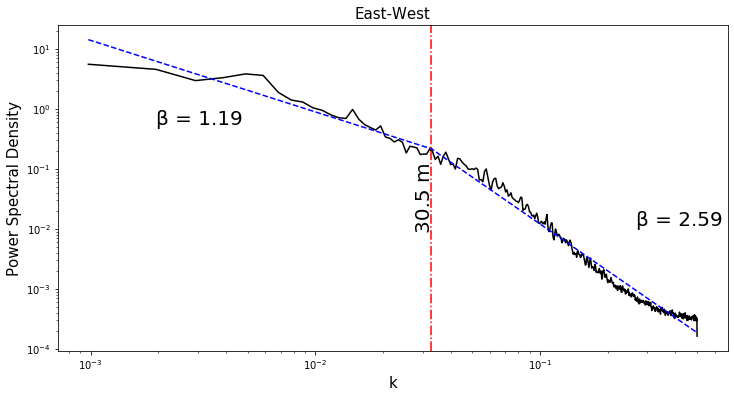

In [10]:
segment_plot(freqs, psd_x, resolution, len(imarray), ['East-West',arg_tif],0)

## North-South Break

β_0: 0.037577199655304566
β_1: 2.4468000027813392
Break in meters: 102.99954154370612
----------------------


(0.037577199655304566, 2.4468000027813392, 102.99954154370612)

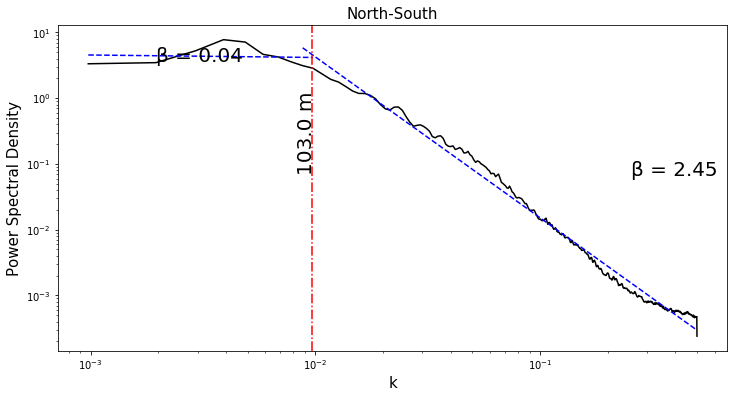

In [11]:
segment_plot(freqs, psd_y, resolution, len(imarray), ['North-South',arg_tif],0)

# Directional

## Rotation Function

In [12]:
### This function rotates the image around center with angle theta (in deg) and crops the image in half.
### Positive theta roration means counter clockwise.
### The inputs are:
### "image": The image that we want to rotate
### "theta": Rotation angle

def subimage(image, theta):
    # Read the image dimension 
    rows,cols = image.shape
    
    # The center of the image (the half of image length)
    center = (int(cols/2),int(rows/2))   
    
    # Find the transformation matrix and rotate
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 )
    image = cv2.warpAffine( image, matrix, (rows,cols) )

    # Crop the transformed image from the center into half
    image = image[int(cols/4):int(cols-cols/4), int(rows/4):int(rows-rows/4)]

    return image

## Clockwise rotation of the image and computing the directional psd

β_0: 1.237914009180683
β_1: 2.588585379406605
Break in meters: 24.591003752830677
----------------------
β_0: 1.2732810765907292
β_1: 3.435654721868208
Break in meters: 17.05041121247818
----------------------
β_0: 1.3321467725459784
β_1: 3.459371346837443
Break in meters: 17.234884915041302
----------------------
β_0: 1.3707255874533018
β_1: 3.339597304501821
Break in meters: 19.03617310047413
----------------------
β_0: 1.3537189224086028
β_1: 3.283487692424628
Break in meters: 21.664311348997625
----------------------
β_0: 1.2965749330683192
β_1: 3.1882317836155543
Break in meters: 25.472451275143122
----------------------
β_0: 0.8494835427107629
β_1: 3.0255374082929705
Break in meters: 42.14586777619438
----------------------
β_0: 0.7055965267787584
β_1: 2.9980267284780857
Break in meters: 45.822912817663905
----------------------
β_0: 0.7021828793295122
β_1: 2.9480183917844314
Break in meters: 46.198670705508206
----------------------
β_0: 0.9434546509837144
β_1: 2.969311373311335

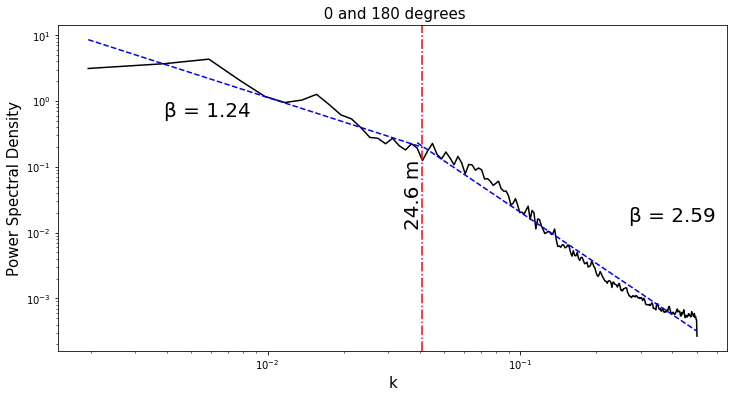

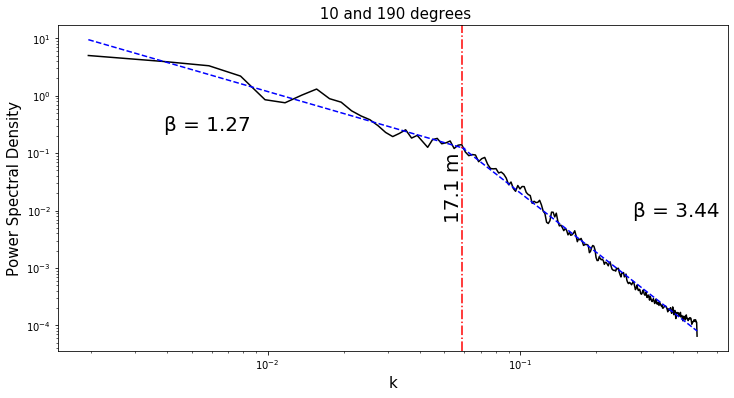

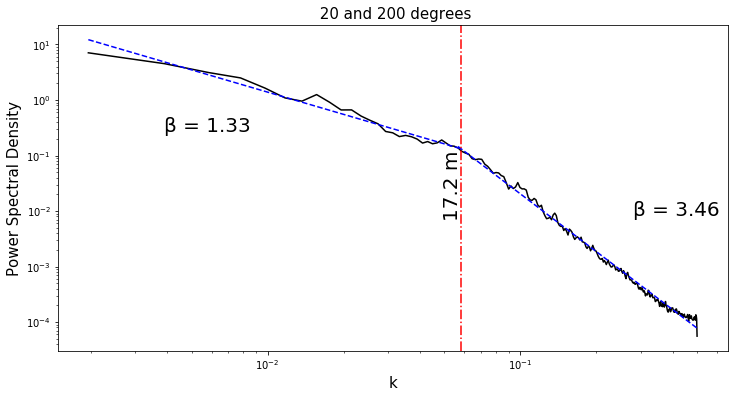

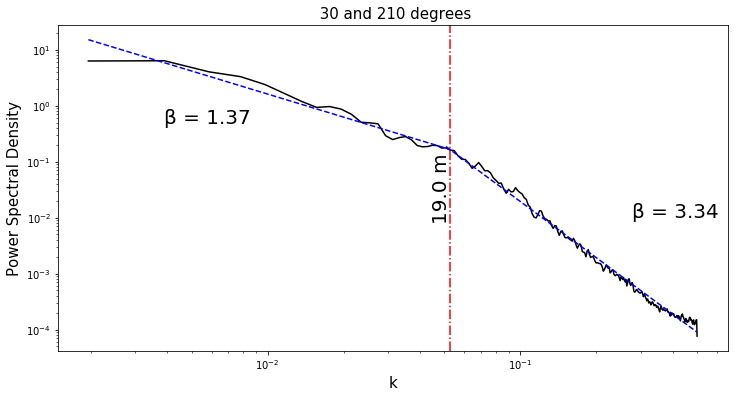

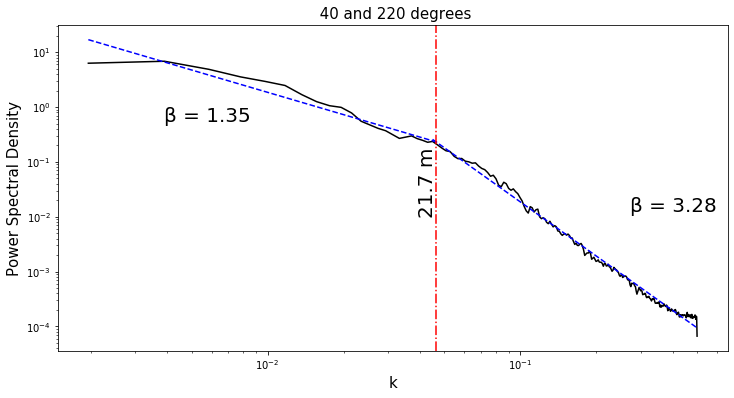

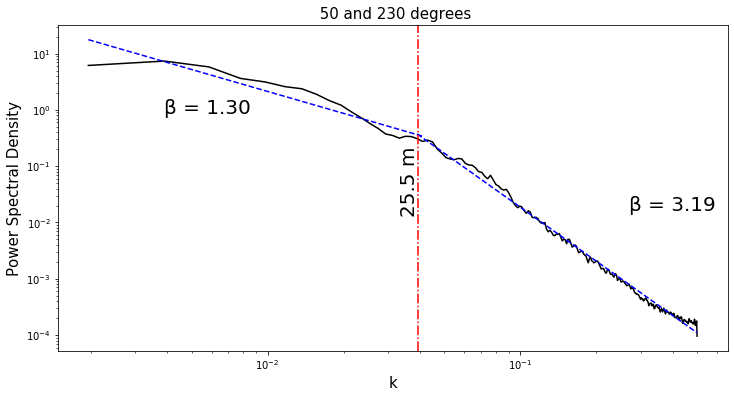

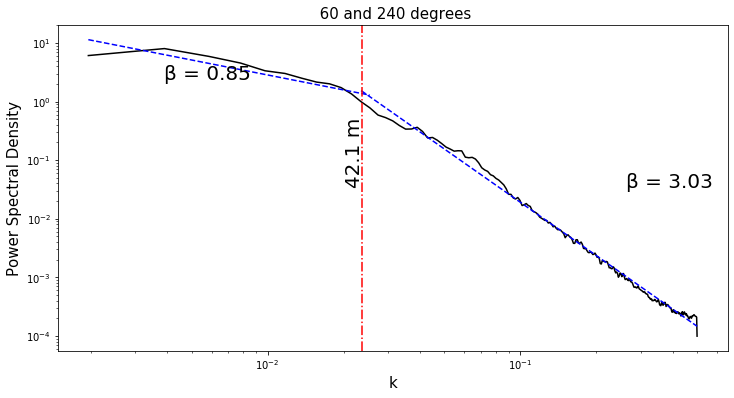

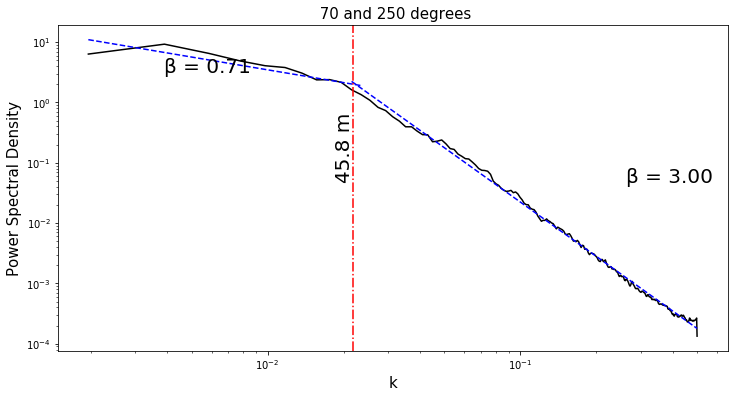

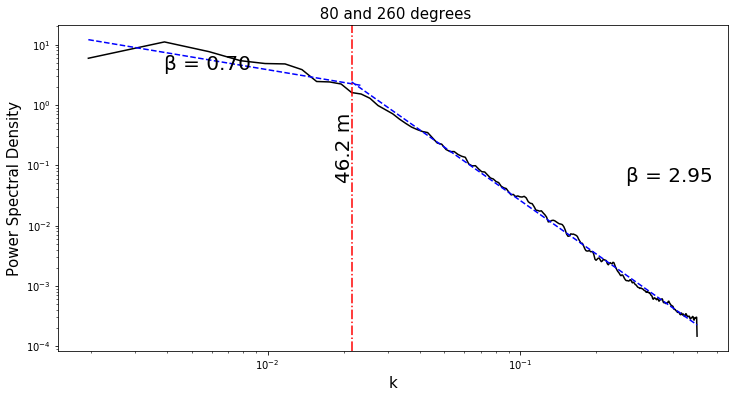

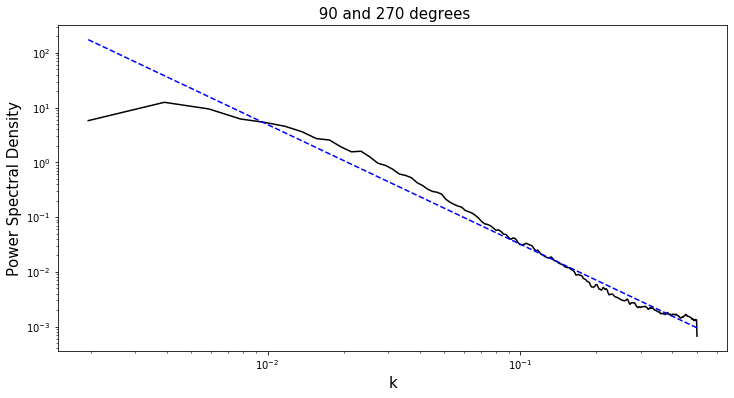

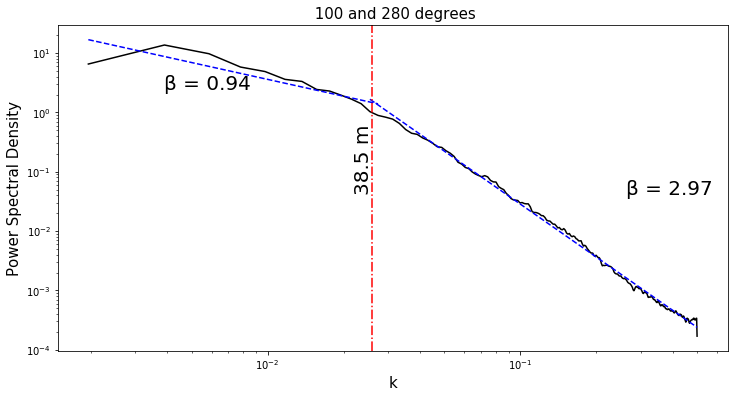

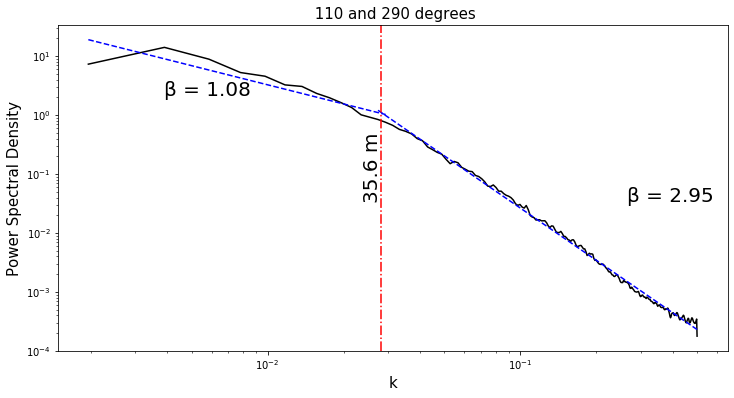

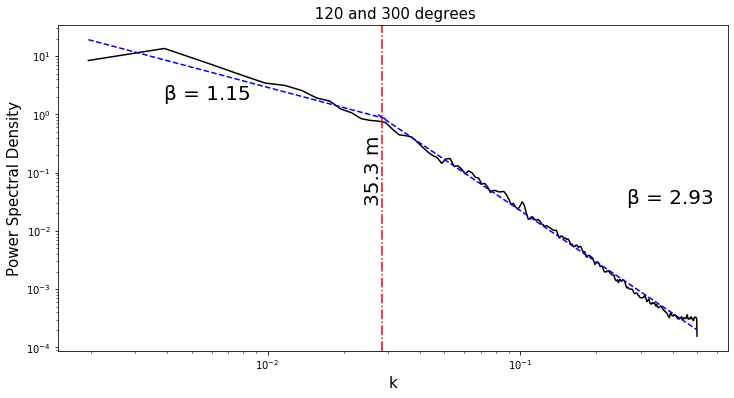

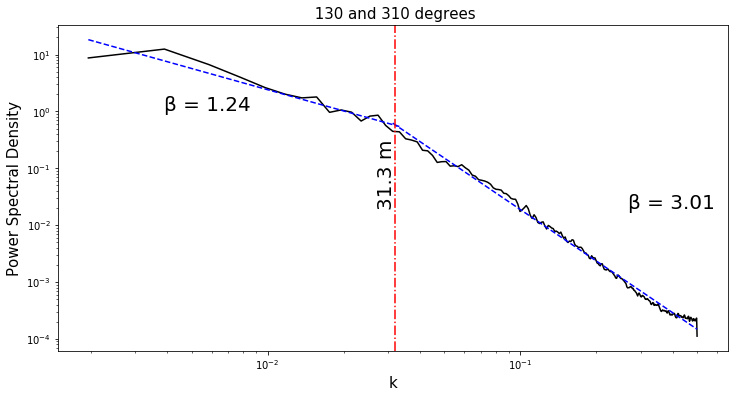

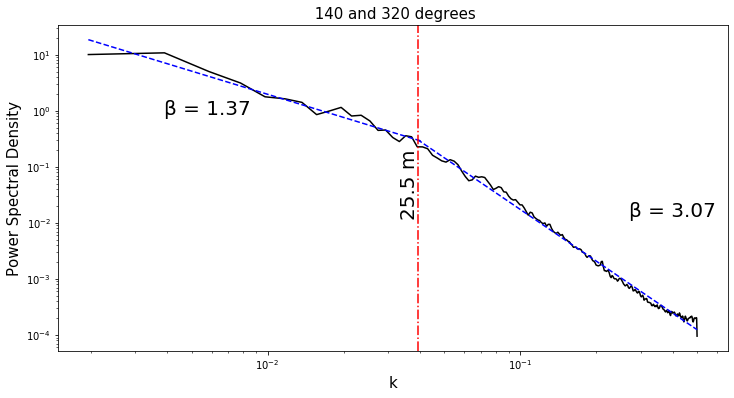

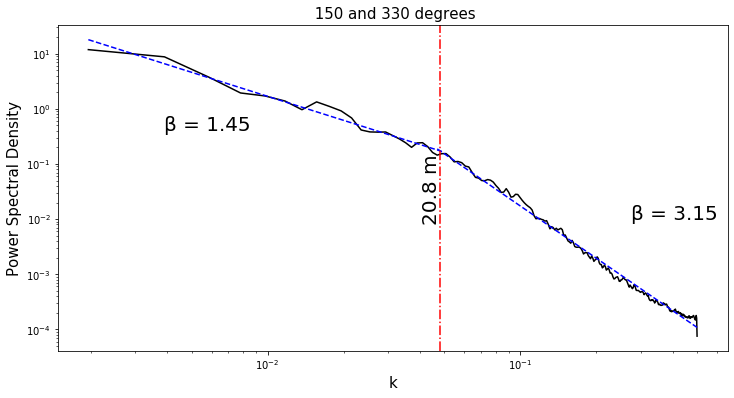

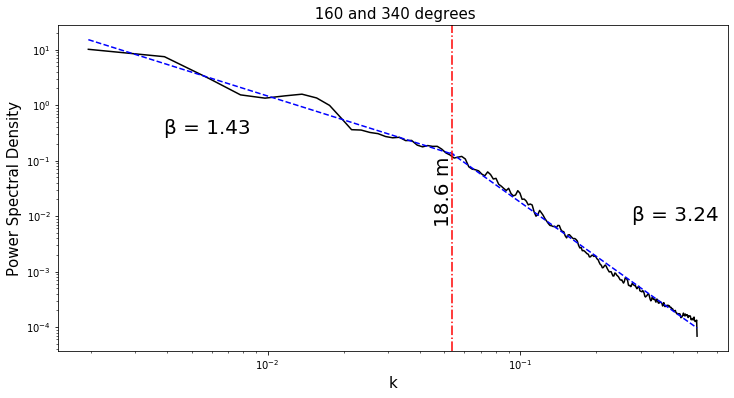

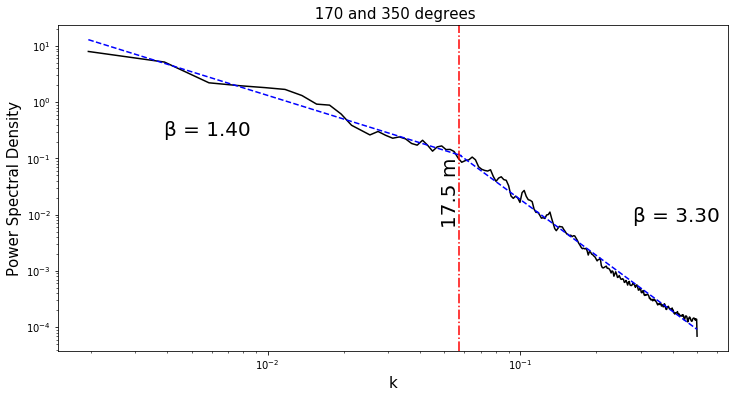

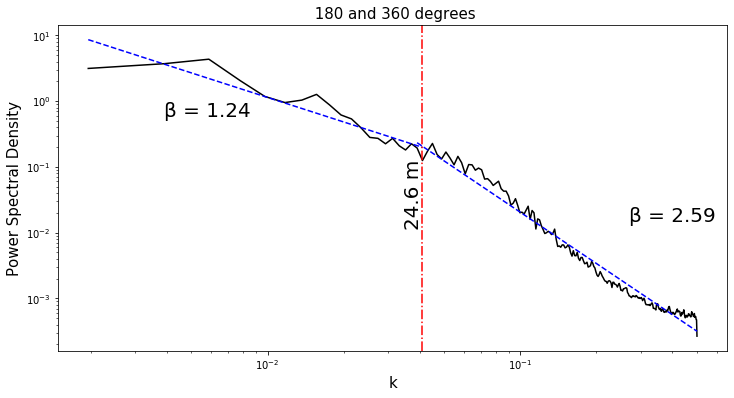

In [13]:
# Initial values for powerlaw fit and break
b0 = []
b1 = []
brk = []

# Rotate the image 10 degree by 10 degree and compute the psd for each direction
for i in range(0,190,10):
    
    # Rotation and crop
    image = subimage(imarray,theta=-i)
    
    # psd and frequency computation
    psd_x, freqs = psd_(image,'E')

    # Powerlaw fits and breakpoint
    b0_, b1_, brk_ = segment_plot(freqs, psd_x, resolution, int(len(imarray)/2),
                                  [' {} and {} degrees'.format(i , i+180),arg_tif],0)
    b0.append(b0_)
    b1.append(b1_)
    brk.append(brk_)

## Directional psd distribution

### Spectral exponents for the lower frequencies (smaller values) and higher frequencies (larger values) 

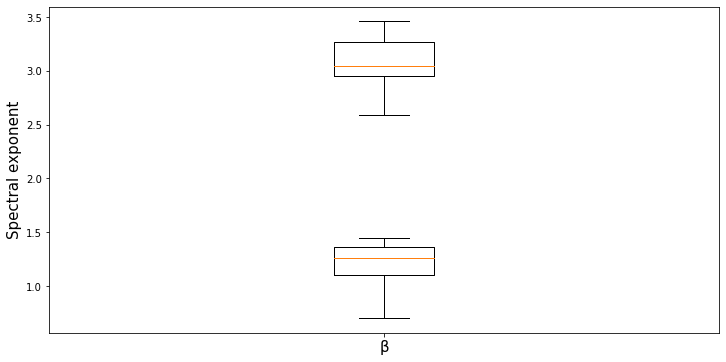

In [14]:
# First and Second powerlaw statistics in directional analysis
green_diamond = dict(markerfacecolor='g', marker='D')
plt.figure(figsize=(12, 6))
plt.boxplot(list(filter(None,b0)))
plt.boxplot(list(filter(None,b1)))
plt.xticks([1],['\u03B2'],fontsize=15)
plt.ylabel('Spectral exponent',fontsize=15)
# plt.savefig('Spectral_exponent_{}.png'.format(arg_tif),dpi=300)
plt.show()

## Scale breaks

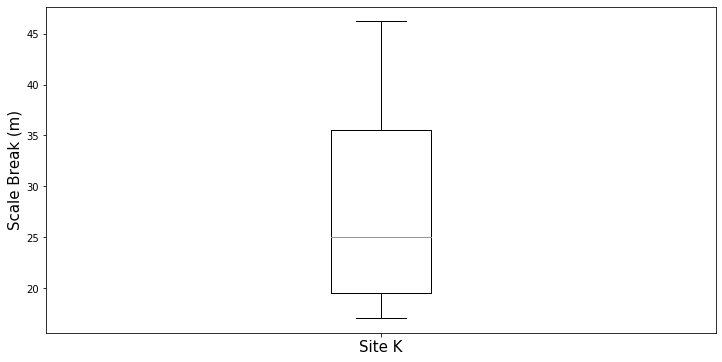

In [15]:
# Statistics for scale breaks (breakpoints) in directional analysis
green_diamond = dict(markerfacecolor='g', marker='D')
plt.figure(figsize=(12, 6))
plt.boxplot(list(filter(None,brk)))
plt.xticks([1],['Site K'],fontsize=15)
plt.ylabel('Scale Break (m)',fontsize=15)
# plt.savefig('Scale_Break_{}.png'.format(arg_tif),dpi=300)
plt.show()

## Low frequncy ($\beta_0$) and breaks as a function of direction

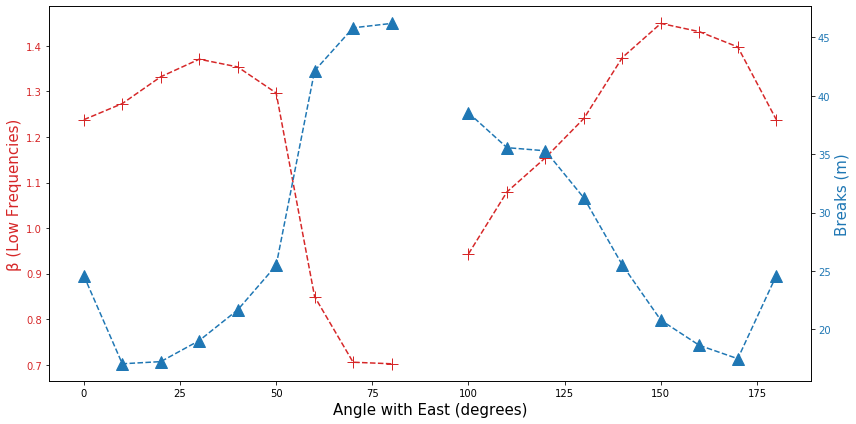

In [16]:
# 10 by 10 degrees directions
angle = np.arange(0, 190, 10)

# Axis one (Low frequencies)
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Angle with East (degrees)',fontsize=15)
ax1.set_ylabel('\u03B2 (Low Frequencies)', color=color,fontsize=15)
ax1.plot(angle, b0,'--+' ,color=color, markersize=12)
ax1.tick_params(axis='y', labelcolor=color)

# Axis two (Breakpoints)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Breaks (m)', color=color, fontsize=15)  
ax2.plot(angle, brk,'--^' ,color=color,markersize=12)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
# plt.savefig('lowfreq_break_{}.png.format(arg_tif)',dpi=300)
plt.show()

## High frequncy ($\beta_1$) and breaks as a function of direction

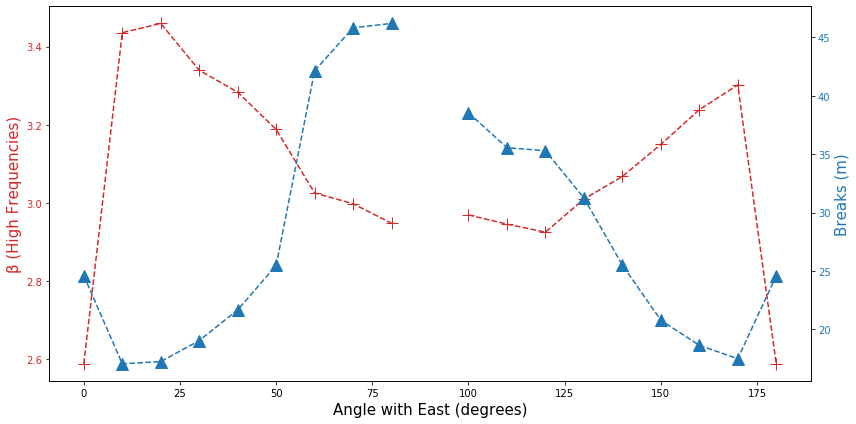

In [17]:
# 10 by 10 degrees directions
angle = np.arange(0, 190, 10)

# Axis one (High frequencies)
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Angle with East (degrees)',fontsize=15)
ax1.set_ylabel('\u03B2 (High Frequencies)', color=color,fontsize=15)
ax1.plot(angle, np.array(b1),'--+' ,color=color, markersize=12)
ax1.tick_params(axis='y', labelcolor=color)

# Axis two (Breakpoints)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Breaks (m)', color=color, fontsize=15)  
ax2.plot(angle, brk,'--^' ,color=color,markersize=12)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
# plt.savefig('highfreq_break_{}.png'.format(arg_tif),dpi=300)
plt.show()

# Wind
## Clean the wind data

**The wind data are selected from the first snowfall until 02/28/2017**

In [18]:
# Choose negative air temperature
wind = wind[wind['air_temp']<0]

# Remove wind_speed_10ft with -9999 
wind = wind[wind['wind_speed_10ft']!=-9999]

# Choose speeds above 5m/s
wind = wind[wind['wind_speed_10ft']>4]

# Rotating Azimuth angles to East West
wind['wind_dir_10ft'] = np.where(wind['wind_dir_10ft'] <=90, 90-wind['wind_dir_10ft'], wind['wind_dir_10ft'])
wind['wind_dir_10ft'] = np.where(wind['wind_dir_10ft'] >90, 450-wind['wind_dir_10ft'], wind['wind_dir_10ft'])

# Transfering wind direction from 0-360 to 0-180 (0 here is East)
wind['wind_dir_10ft'] = np.where(wind['wind_dir_10ft'] > 180, wind['wind_dir_10ft']-180, wind['wind_dir_10ft'])

### Empirical distribution functions of maximum wind speed every 10-min intervals

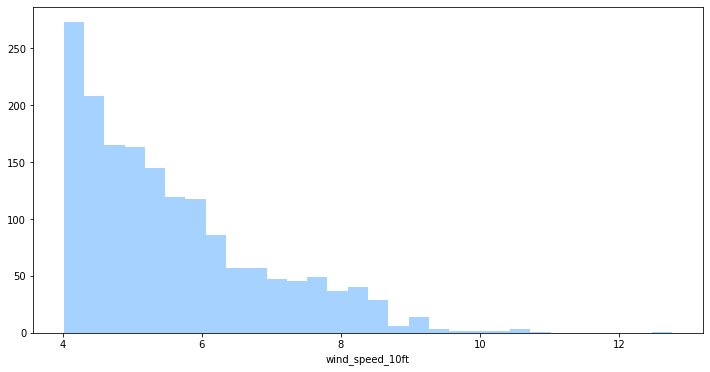

In [19]:
# Plot
plt.figure(figsize=(12, 6))
sns.distplot( wind['wind_speed_10ft'] , color="dodgerblue",kde=False)
plt.show()
# plt.savefig('wind_speed_10ft_{}.png'.format(arg_tif),dpi=300)

## Wind direction, $\beta$ and breaks plot

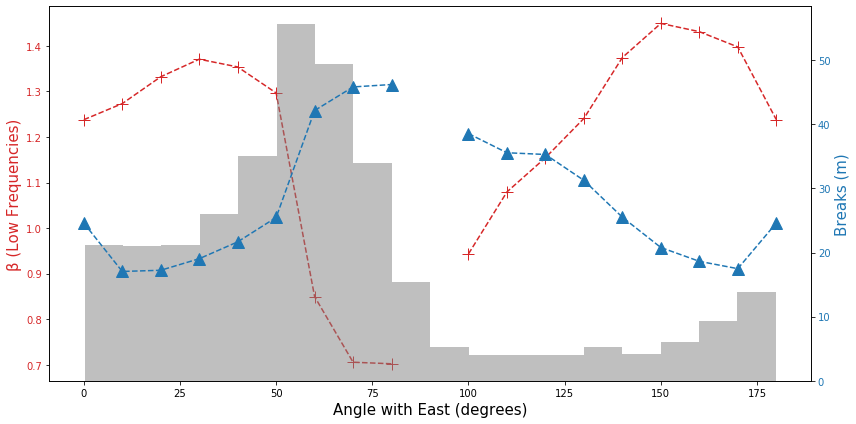

In [20]:
# 10 by 10 degrees directions
angle = np.arange(0, 190, 10)

# Axis one (Low frequencies)
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Angle with East (degrees)',fontsize=15)
ax1.set_ylabel('\u03B2 (Low Frequencies)', color=color,fontsize=15)
ax1.plot(angle, np.array(b0),'--+' ,color=color, markersize=12)
ax1.tick_params(axis='y', labelcolor=color)

# Axis two (Breakpoints)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Breaks (m)', color=color, fontsize=15)  
ax2.plot(angle, np.array(brk),'--^' ,color=color,markersize=12)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout() 

# Axis three (wind speed histogram)
# Hist plot is weighted by 0.02 (the counts are divided by 10)
plt.hist(wind['wind_dir_10ft'],18,histtype ='bar',color='gray',weights=.2*np.ones(len(wind)),alpha = 0.5)
# plt.savefig('Break_Lowfreq_Wind_{}.png'.format(arg_tif),dpi=300)
plt.show()

# snow depth peaks

## Peak distance function

In [21]:
### This function finds the peaks farther than 1m  from each other per each row and column of the image
### The inputs are:
### "im" : Input image
### "resolution": The image resolution
### "direction" : North-South ('N') or East-West ('E') direction
### The output is the distances between snow depth or vegetation metrics' peaks at a specific direction

def peak_diff(im,resolution,direction):
    d = []
    for i in range(0,len(im)):
        # For each column
        if direction == 'N':
            peaks, _ = find_peaks(im[:,i], height=np.mean(im[:,i]),distance=1,width=1)
            d0 = np.diff(peaks)*resolution
            d.append(d0)
         
        # For each row
        elif direction == 'E':
            peaks, _ = find_peaks(im[i,], height=np.mean(im[i,]),distance=1,width=1)
            d0 = np.diff(peaks)*resolution
            d.append(d0)
    return d

## Peak distance distribution plot

In [22]:
### "imarray" : Input image
### "resolution": The image resolution
### "direction" : North-South ('N') or East-West ('E') direction
### "arg" : The title for the plot and the input image file name for saving
### "S": If S==1 it saves the plot

def dist_plot_(imarray,resolution, direction, arg, S):
    # Peak distances at North-South or East-West direction
    lst = peak_diff(imarray,resolution,direction)

    # Convert the distances to a list of distances for distribution plot
    d = []
    for l in range(0,len(lst)):
        d += lst[l].tolist()

    # Initial figure    
    plt.figure(figsize=(12, 6))

    # Count the elements and store as dictionary values
    ctr = collections.Counter(d)
    cnt, val = ctr.values(), ctr.keys()

    # Plot Distance versus frequency of its happening
    plt.plot(list(val),list(cnt)/np.sum(list(cnt))*100,'r^',markersize=8)
    plt.xlabel('Distance (m)',fontsize=15)
    plt.ylabel('Frequency(%)',fontsize=15)
    plt.title('{}'.format(arg[0]),fontsize=15)
    
    # Save the plot
    if S==1:
        plt.savefig('Peak_distance_distribution_{}.png'.format(arg[1]),dpi=300)
    
    # Print the median distance between the peaks at North-South direction
    print('Median peak distance = {} m'.format(np.median(d)))
    

### X-dir

Median peak distance = 12.0 m


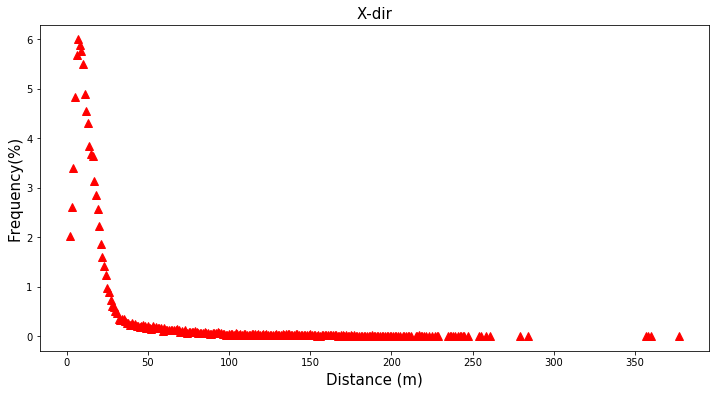

In [23]:
dist_plot_(imarray,resolution,'E', ['X-dir',arg_tif],0)

### Y-dir

Median peak distance = 13.0 m


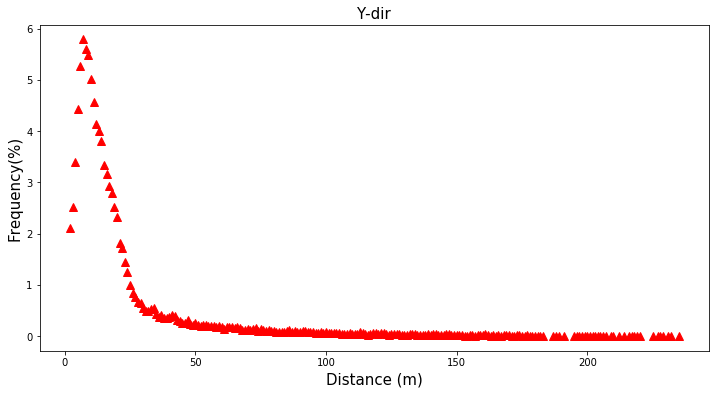

In [24]:
dist_plot_(imarray,resolution,'N', ['Y-dir',arg_tif],0)